# ECG Classification - CNN1D

In [10]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [11]:

with open("ECG5000_train.pickle", "rb") as f:
    train_data = pickle.load(f)
with open("ECG5000_validation.pickle", "rb") as f:
    val_data = pickle.load(f)

X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_val, y_val = val_data[:, 1:], val_data[:, 0]


In [12]:

class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(int(self.y[idx]), dtype=torch.long)


In [13]:

class CNN1D(nn.Module):
    def __init__(self, input_dim=140, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 33, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [14]:

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    evaluate_model(model, val_loader)

def evaluate_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Epoch 1/10, Loss: 0.5269
Epoch 2/10, Loss: 0.3832
Epoch 3/10, Loss: 0.2250
Epoch 4/10, Loss: 0.4731
Epoch 5/10, Loss: 0.0217
Epoch 6/10, Loss: 0.1443
Epoch 7/10, Loss: 0.1914
Epoch 8/10, Loss: 0.3139
Epoch 9/10, Loss: 0.0111
Epoch 10/10, Loss: 0.1963
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       781
           1       0.90      0.95      0.93       590
           2       0.59      0.23      0.33        43
           3       0.72      0.41      0.53        75
           4       0.00      0.00      0.00        11

    accuracy                           0.92      1500
   macro avg       0.63      0.52      0.55      1500
weighted avg       0.90      0.92      0.91      1500



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


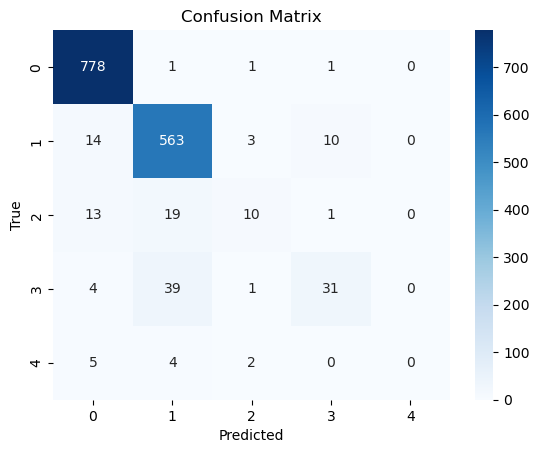

In [15]:

train_dataset = ECGDataset(X_train, y_train)
val_dataset = ECGDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

model = CNN1D()
train_model(model, train_loader, val_loader, epochs=10)
